In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                    | 0/60000 [00:00<?, ?it/s]

 13%|██████████▊                                                                           | 7582/60000 [00:00<00:00, 75808.50it/s]

 25%|█████████████████████▋                                                               | 15271/60000 [00:00<00:00, 76440.07it/s]

 38%|████████████████████████████████▍                                                    | 22916/60000 [00:00<00:00, 71275.86it/s]

 51%|███████████████████████████████████████████                                          | 30402/60000 [00:00<00:00, 72628.50it/s]

 64%|██████████████████████████████████████████████████████                               | 38119/60000 [00:00<00:00, 74219.27it/s]

 76%|████████████████████████████████████████████████████████████████▌                    | 45565/60000 [00:00<00:00, 72013.50it/s]

 89%|███████████████████████████████████████████████████████████████████████████▍         | 53228/60000 [00:00<00:00, 73470.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 73672.24it/s]

  0%|                                                                                                    | 0/10000 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████▊                    | 7653/10000 [00:00<00:00, 76520.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 73074.55it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 74x07uh4


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-74x07uh4:best, 409.59MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.8


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                      | 0/750 [00:00<?, ?it/s]

  0%|▏                                                                                             | 1/750 [00:00<06:31,  1.91it/s]

  2%|█▌                                                                                           | 13/750 [00:00<00:27, 27.01it/s]

  3%|███                                                                                          | 25/750 [00:00<00:15, 48.00it/s]

  5%|████▉                                                                                        | 40/750 [00:00<00:09, 72.65it/s]

  7%|██████▋                                                                                      | 54/750 [00:00<00:07, 89.86it/s]

  9%|████████▎                                                                                   | 68/750 [00:01<00:06, 103.16it/s]

 11%|██████████▎                                                                                 | 84/750 [00:01<00:05, 117.70it/s]

 13%|████████████                                                                                | 98/750 [00:01<00:05, 123.76it/s]

 15%|█████████████▌                                                                             | 112/750 [00:01<00:04, 127.88it/s]

 17%|███████████████▎                                                                           | 126/750 [00:01<00:04, 131.13it/s]

 19%|█████████████████                                                                          | 141/750 [00:01<00:04, 134.36it/s]

 21%|██████████████████▉                                                                        | 156/750 [00:01<00:04, 136.52it/s]

 23%|████████████████████▋                                                                      | 171/750 [00:01<00:04, 138.08it/s]

 25%|██████████████████████▌                                                                    | 186/750 [00:01<00:04, 138.85it/s]

 27%|████████████████████████▍                                                                  | 201/750 [00:01<00:03, 139.70it/s]

 29%|██████████████████████████▏                                                                | 216/750 [00:02<00:03, 140.62it/s]

 31%|████████████████████████████                                                               | 231/750 [00:02<00:03, 141.21it/s]

 33%|█████████████████████████████▊                                                             | 246/750 [00:02<00:03, 140.63it/s]

 35%|███████████████████████████████▋                                                           | 261/750 [00:02<00:03, 141.05it/s]

 37%|█████████████████████████████████▍                                                         | 276/750 [00:02<00:03, 141.48it/s]

 39%|███████████████████████████████████▎                                                       | 291/750 [00:02<00:03, 141.70it/s]

 41%|█████████████████████████████████████▏                                                     | 306/750 [00:02<00:03, 141.84it/s]

 43%|██████████████████████████████████████▉                                                    | 321/750 [00:02<00:03, 141.82it/s]

 45%|████████████████████████████████████████▊                                                  | 336/750 [00:02<00:02, 142.01it/s]

 47%|██████████████████████████████████████████▌                                                | 351/750 [00:03<00:02, 142.14it/s]

 49%|████████████████████████████████████████████▍                                              | 366/750 [00:03<00:02, 141.20it/s]

 51%|██████████████████████████████████████████████▏                                            | 381/750 [00:03<00:02, 141.43it/s]

 53%|████████████████████████████████████████████████                                           | 396/750 [00:03<00:02, 141.72it/s]

 55%|█████████████████████████████████████████████████▊                                         | 411/750 [00:03<00:02, 141.72it/s]

 57%|███████████████████████████████████████████████████▋                                       | 426/750 [00:03<00:02, 141.75it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 441/750 [00:03<00:02, 141.76it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 456/750 [00:03<00:02, 141.75it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 471/750 [00:03<00:01, 141.95it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 486/750 [00:03<00:01, 141.52it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 501/750 [00:04<00:01, 140.92it/s]

 69%|██████████████████████████████████████████████████████████████▌                            | 516/750 [00:04<00:01, 141.13it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 531/750 [00:04<00:01, 141.60it/s]

 73%|██████████████████████████████████████████████████████████████████▏                        | 546/750 [00:04<00:01, 141.84it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 561/750 [00:04<00:01, 141.63it/s]

 77%|█████████████████████████████████████████████████████████████████████▉                     | 576/750 [00:04<00:01, 141.68it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 591/750 [00:04<00:01, 142.02it/s]

 81%|█████████████████████████████████████████████████████████████████████████▌                 | 606/750 [00:04<00:01, 142.11it/s]

 83%|███████████████████████████████████████████████████████████████████████████▎               | 621/750 [00:04<00:00, 142.14it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 636/750 [00:05<00:00, 142.17it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 651/750 [00:05<00:00, 141.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 666/750 [00:05<00:00, 141.95it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 681/750 [00:05<00:00, 142.06it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 696/750 [00:05<00:00, 142.15it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 711/750 [00:05<00:00, 142.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 726/750 [00:05<00:00, 142.30it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 741/750 [00:05<00:00, 142.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:05<00:00, 127.95it/s]

train - OK


  0%|                                                                                                      | 0/188 [00:00<?, ?it/s]

  2%|██                                                                                            | 4/188 [00:00<00:04, 37.43it/s]

 10%|████████▉                                                                                    | 18/188 [00:00<00:01, 94.91it/s]

 17%|███████████████▋                                                                            | 32/188 [00:00<00:01, 114.47it/s]

 24%|██████████████████████▌                                                                     | 46/188 [00:00<00:01, 123.69it/s]

 32%|█████████████████████████████▎                                                              | 60/188 [00:00<00:00, 128.80it/s]

 40%|████████████████████████████████████▋                                                       | 75/188 [00:00<00:00, 132.75it/s]

 47%|███████████████████████████████████████████▌                                                | 89/188 [00:00<00:00, 134.16it/s]

 55%|█████████████████████████████████████████████████▊                                         | 103/188 [00:00<00:00, 135.28it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 117/188 [00:00<00:00, 136.15it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 131/188 [00:01<00:00, 136.61it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 145/188 [00:01<00:00, 137.10it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 159/188 [00:01<00:00, 137.36it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 173/188 [00:01<00:00, 137.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▌| 187/188 [00:01<00:00, 137.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 124.78it/s]

val - OK


  0%|                                                                                                      | 0/157 [00:00<?, ?it/s]

  2%|█▊                                                                                            | 3/157 [00:00<00:05, 29.47it/s]

 11%|██████████                                                                                   | 17/157 [00:00<00:01, 92.82it/s]

 20%|██████████████████▏                                                                         | 31/157 [00:00<00:01, 113.81it/s]

 29%|██████████████████████████▎                                                                 | 45/157 [00:00<00:00, 123.95it/s]

 38%|██████████████████████████████████▌                                                         | 59/157 [00:00<00:00, 129.40it/s]

 46%|██████████████████████████████████████████▊                                                 | 73/157 [00:00<00:00, 132.52it/s]

 55%|██████████████████████████████████████████████████▉                                         | 87/157 [00:00<00:00, 134.62it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 101/157 [00:00<00:00, 136.14it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 115/157 [00:00<00:00, 136.92it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 129/157 [00:01<00:00, 137.50it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 143/157 [00:01<00:00, 138.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 124.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 122.73it/s]

test InD - OK


  0%|                                                                                                      | 0/100 [00:00<?, ?it/s]

 15%|█████████████▊                                                                              | 15/100 [00:00<00:00, 142.69it/s]

 30%|███████████████████████████▌                                                                | 30/100 [00:00<00:00, 143.31it/s]

 45%|█████████████████████████████████████████▍                                                  | 45/100 [00:00<00:00, 143.50it/s]

 60%|███████████████████████████████████████████████████████▏                                    | 60/100 [00:00<00:00, 143.58it/s]

 75%|█████████████████████████████████████████████████████████████████████                       | 75/100 [00:00<00:00, 143.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 90/100 [00:00<00:00, 143.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 143.45it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(48000, 3, 32, 32) (48000, 2048) (48000, 256) (48000, 10) (48000,)
(12000, 3, 32, 32) (12000, 2048) (12000, 256) (12000, 10) (12000,)
(10000, 3, 32, 32) (10000, 2048) (10000, 256) (10000, 10) (10000,)
(6400, 3, 32, 32) (6400, 2048) (6400, 256) (6400, 10)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


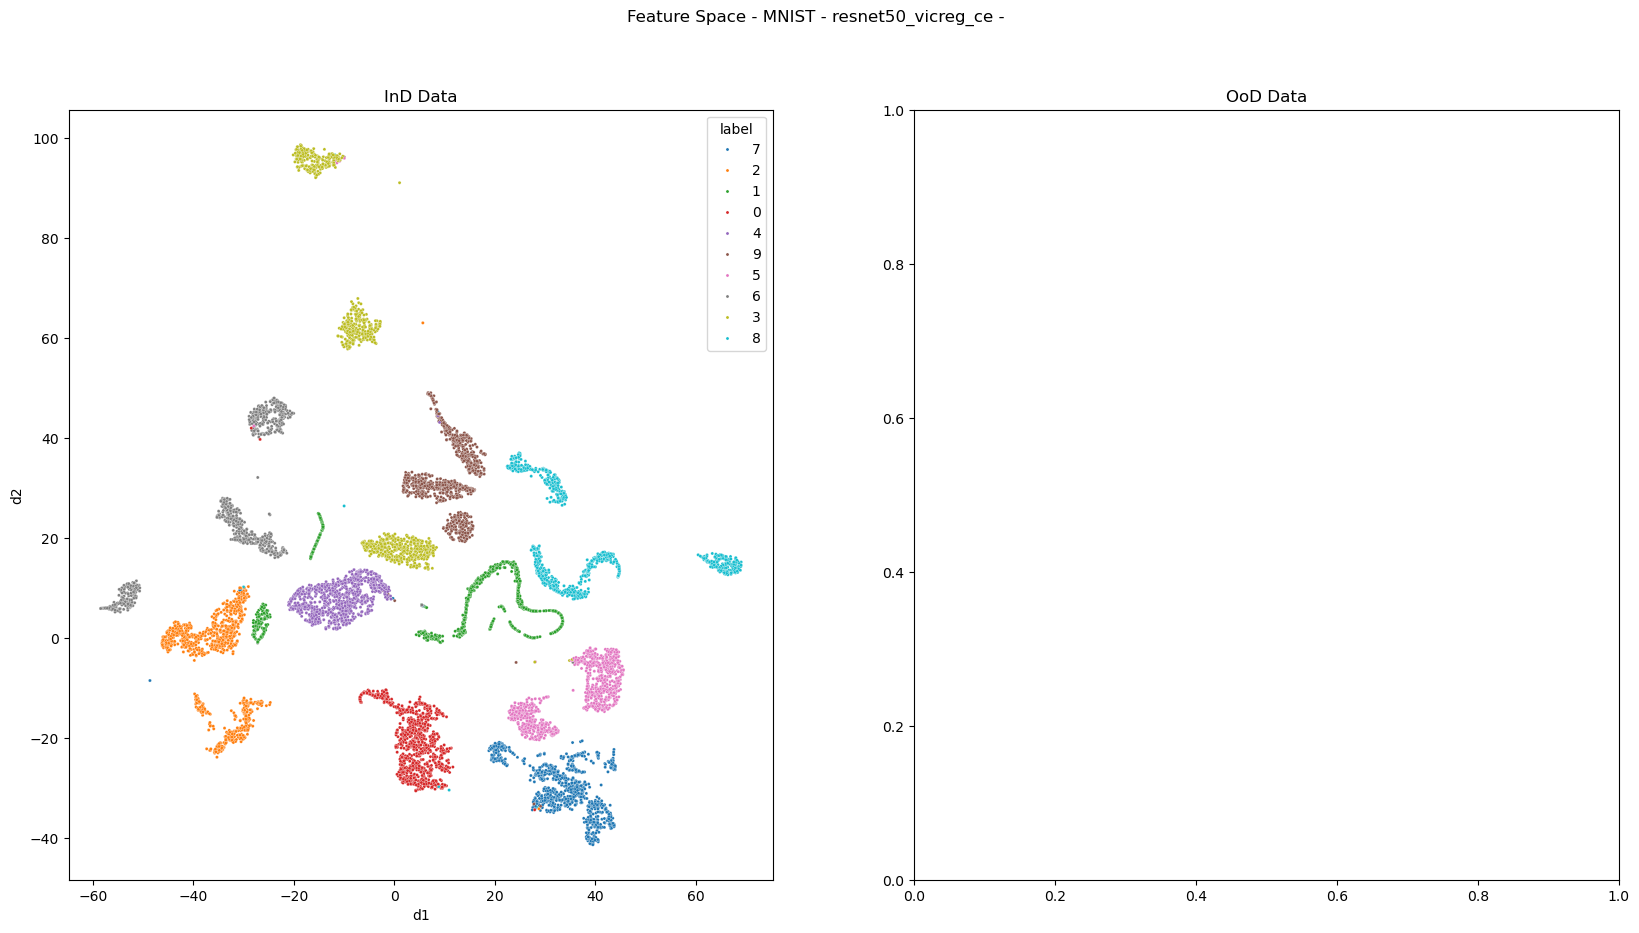

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

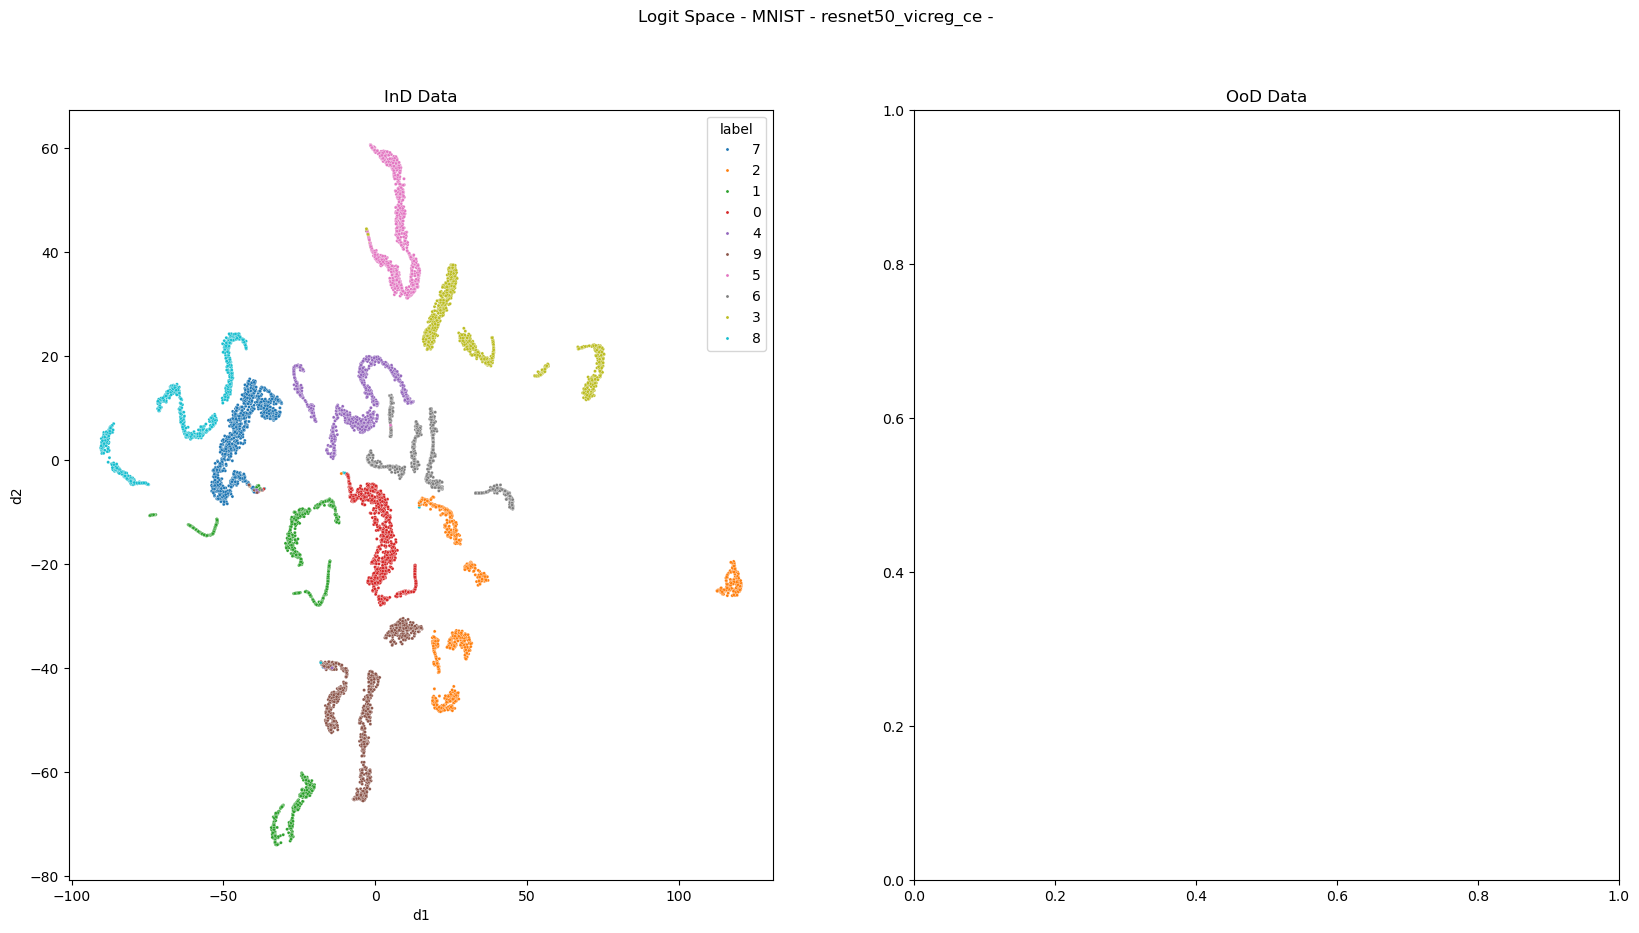

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:03<00:09,  3.17s/it]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:06<00:06,  3.27s/it]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:09<00:03,  3.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.25s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.24s/it]

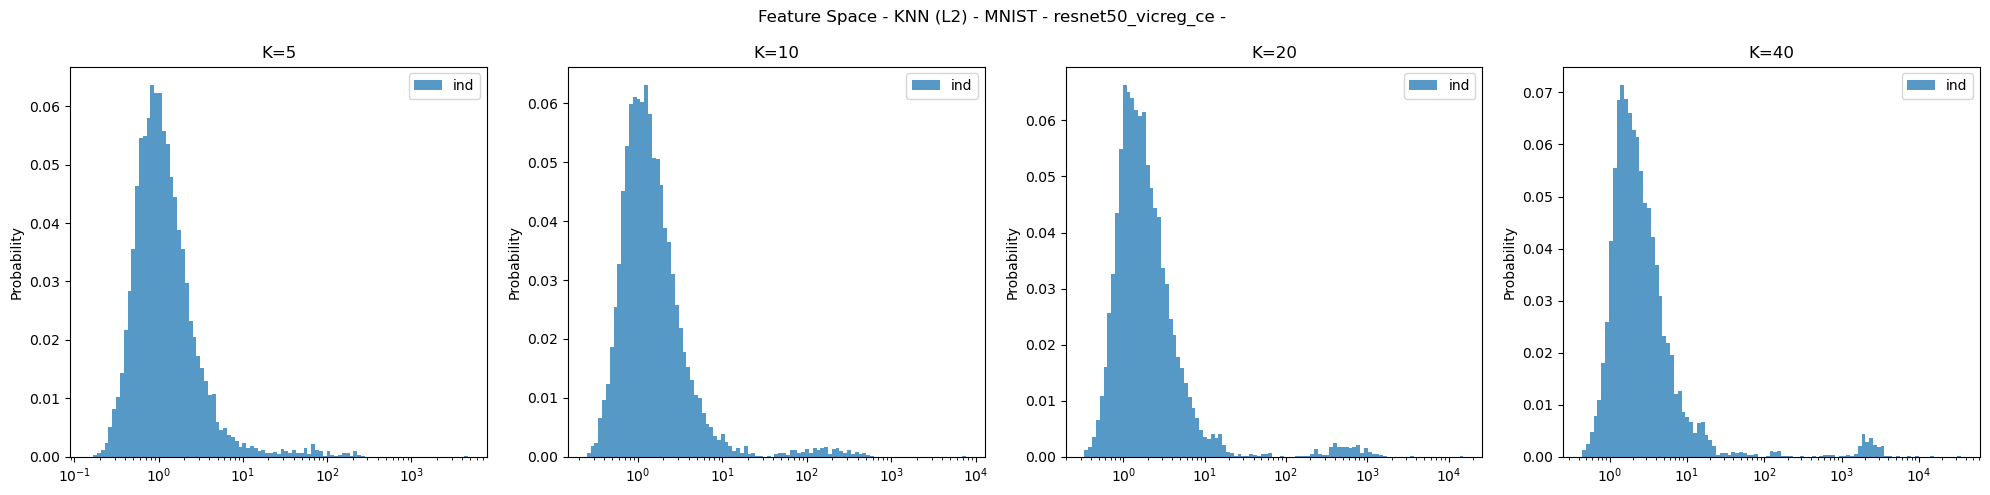

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:03<00:09,  3.14s/it]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:06<00:06,  3.16s/it]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:09<00:03,  3.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.19s/it]

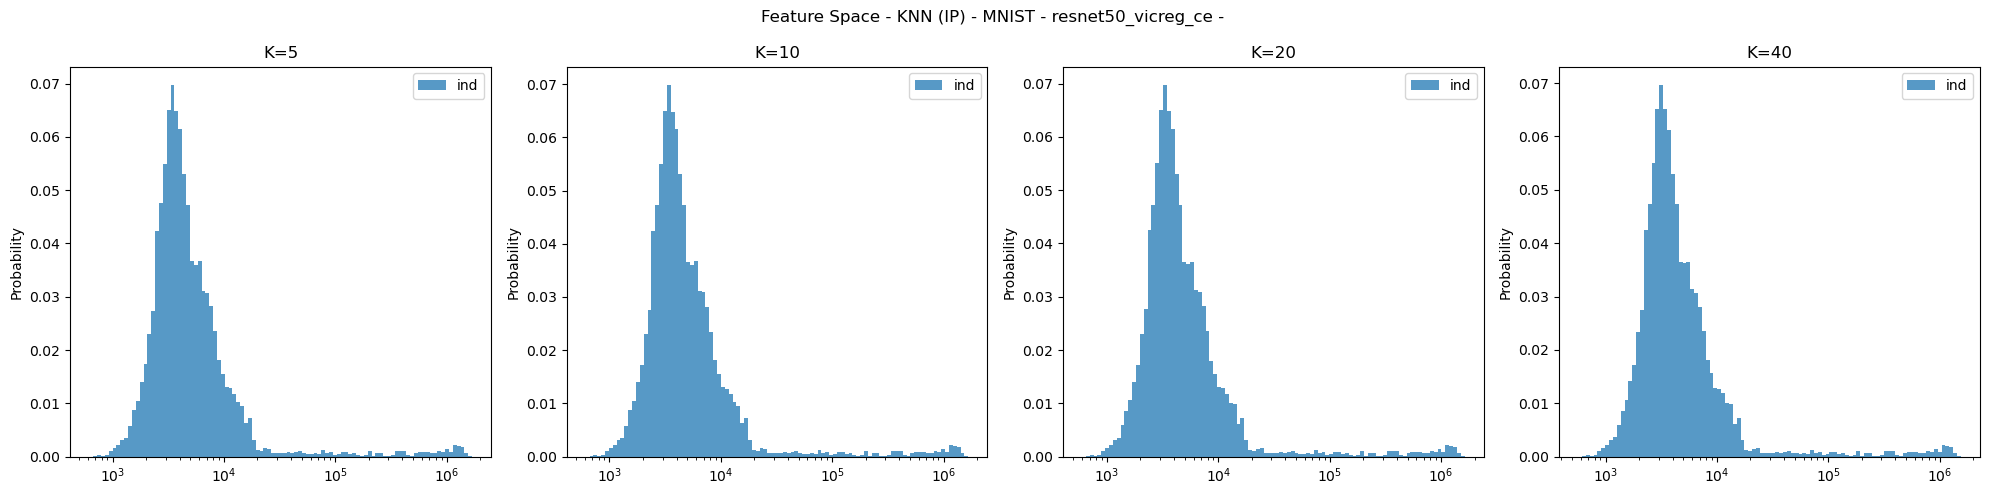

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:00<00:00,  5.38it/s]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:00<00:00,  5.23it/s]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:00<00:00,  4.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.58it/s]

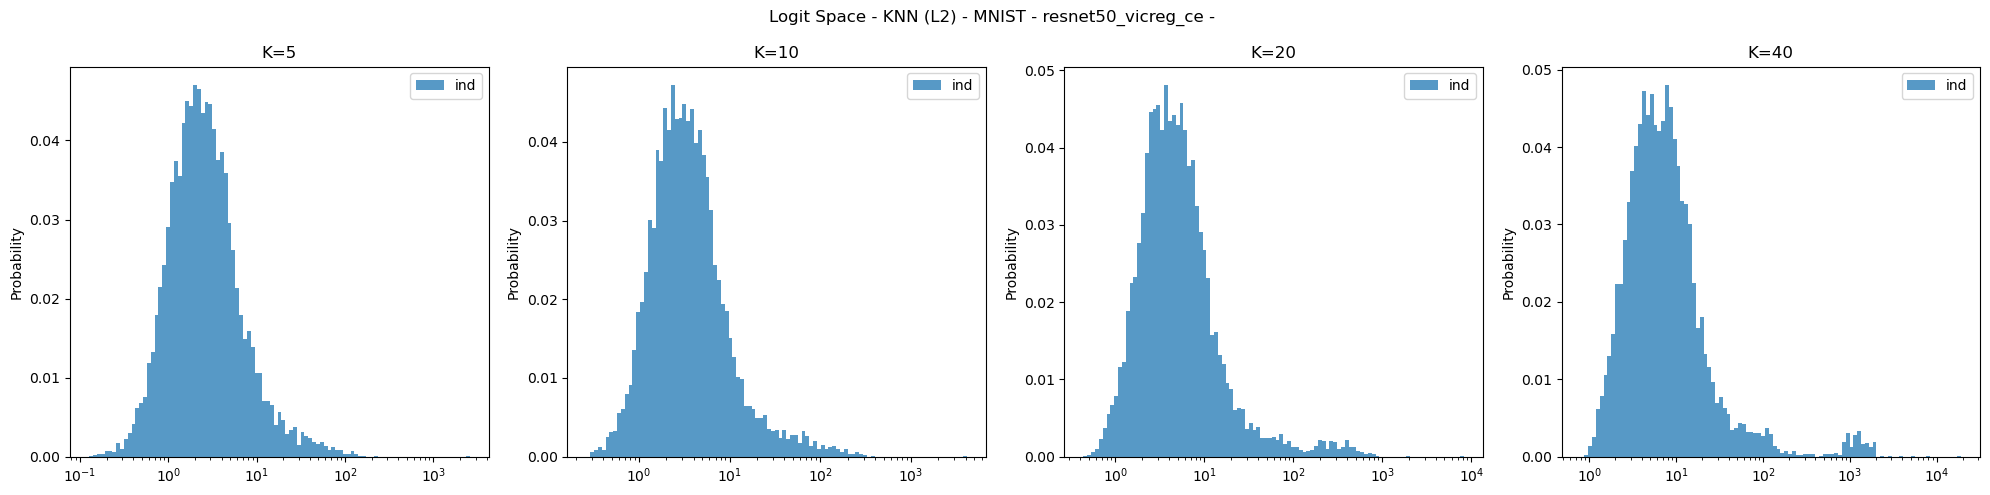

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:00<00:00,  5.95it/s]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:00<00:00,  5.80it/s]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:00<00:00,  5.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.95it/s]

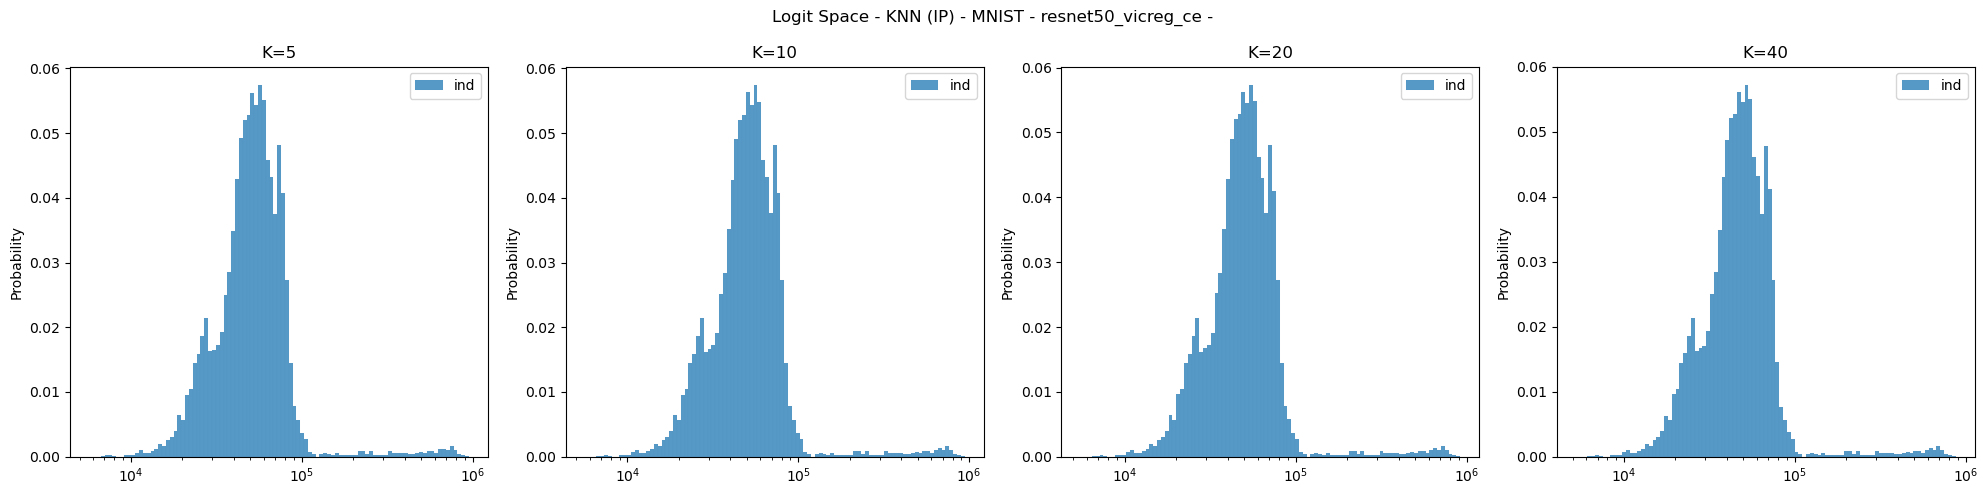

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

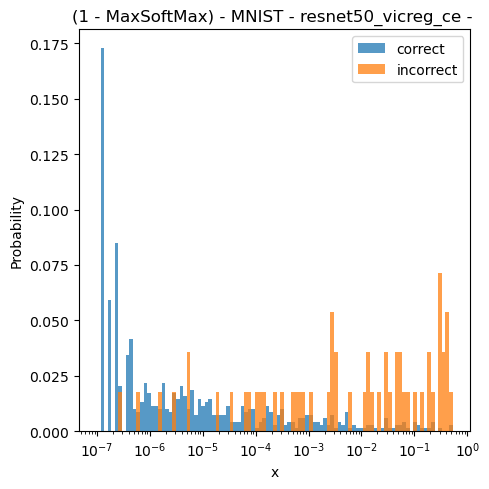

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()